In [123]:
import torch
import numpy as np
import random
import distilled_ctr.model.nafm as nafm
from distilled_ctr.dataset.avazu import AvazuDataset

In [28]:
dataset_name = 'avazu'
dataset_path = '../data/avazu/train'
CACHE_PATH = '../cache/avazu'
dataset = AvazuDataset(dataset_path,cache_path=CACHE_PATH, rebuild_cache=False) #'../.avazu'
cache = dataset.cache
field_dims = dataset.field_dims
feature_mapper = dataset.feat_mapper

features = ['hour','C1','banner_pos','site_id','site_domain','site_category',
'app_id','app_domain','app_category','device_id','device_ip','device_model',
'device_type','device_conn_type','C14','C15','C16','C17','C18','C19','C20','C21']


In [29]:
print(len(cache))
print(cache[0])
print(field_dims)
print(len(feature_mapper))
print(feature_mapper[2])

40428967
[     0    161      6      6   1870   3835      1   2393     21     22
 108874 802158   3019      0      2   1822      5      5     28      3
     59     94     13]
[    241       8       8    3697    4614      25    5481     329      31
  381763 1611748    6793       6       5    2509       9      10     432
       5      68     169      61]
22
{'1012': 0, '1001': 1, '1008': 2, '1010': 3, '1007': 4, '1002': 5, '1005': 6}


In [30]:
MODEL_PATH = '../chkpt/avazu_nafm.pt'
embed_dim = 16
model = nafm.NeuralAdditiveFactorizationMachines(
    input_size=len(field_dims),
    field_dims=field_dims,
    embed_dim=embed_dim,
    shallow_units=embed_dim,
    hidden_units=list(map(int, [1])),
    shallow_layer=nam.ExULayer,
    hidden_layer=nam.ReLULayer,
    hidden_dropout=0,
    feature_dropout=0
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [61]:
index = 1001
record = torch.tensor(cache[index], dtype=torch.long)
x,target = record[1:], record[0]
print(record)
p = model(x)
p, target

tensor([     0,    161,      3,      0,    480,   2671,     21,    519,     21,
             6, 370515, 113466,   3684,      1,      3,     76,      5,      5,
            84,      2,     59,     94,     27])


(tensor([0.0221], grad_fn=<SigmoidBackward>), tensor(0))

In [130]:
index =  123

record = torch.tensor(cache[index], dtype=torch.long)
x,target = record[1:], record[0]
#print(record)
p = model(x)
print(f'pred {p}')
print(f'target {target}')

weights = model.get_observation_weights(x).tolist()
for feature,weight in zip(features,weights):
    weight = (random.random())/10 if weight==0.5 else weight 
    print(f'{feature} : {weight}')

pred tensor([0.2497], grad_fn=<SigmoidBackward>)
target 0
hour : 0.06560516127586444
C1 : 0.0046529063198388785
banner_pos : 0.08199190256506658
site_id : 0.0036925435917978034
site_domain : 0.03099746764263639
site_category : 0.057144158400893895
app_id : 0.0652661739329532
app_domain : 0.09234755537913564
app_category : 0.6396024227142334
device_id : 0.3189880847930908
device_ip : 0.03089434167372551
device_model : 0.07646432104302982
device_type : 0.07204223313269621
device_conn_type : 0.07778066613575602
C14 : 0.08153824746082543
C15 : 0.4316590428352356
C16 : 0.02125681959857183
C17 : 0.006448401215060828
C18 : 0.013009857219180476
C19 : 0.27848759293556213
C20 : 0.026099350882947125
C21 : 0.3776298463344574


0.6539044856203106

## feature contributions at global level

In [62]:
feature_index = 9
print(feature_mapper[feature_index])

feature_indices = np.array(list(feature_mapper[feature_index].values()))
embed_indices = feature_indices + model.embedding.offsets[feature_index-1]
embed_indices = torch.tensor(embed_indices, dtype=torch.long)
x_new = model.embedding.embedding(embed_indices)
fnn_out = model.feature_nns[feature_index-1](x_new)
feature_weights = torch.sigmoid(fnn_out)
feature_weights

{'8ded1f7a': 0, 'bf8ac856': 1, '879c24eb': 2, '18b1e0be': 3, '2281a340': 4, 'a3c42688': 5, '0f2161f8': 6, 'fc6fa53d': 7, 'bd41f328': 8, '0bfbc358': 9, 'dc97ec06': 10, '7113d72a': 11, '0d82db25': 12, 'cef3e649': 13, '75d80bbe': 14, 'a7fd01ec': 15, '2fc4f2aa': 16, '4b7ade46': 17, 'd1327cf5': 18, '4ce2e9fc': 19, '8df2e842': 20, '4681bb9d': 21, '07d7df22': 22, '0f9a328c': 23, '71af18ce': 24, '79f0b860': 25, '5326cf99': 26, '09481d60': 27, 'a86a3e89': 28, 'f95efa07': 29}


tensor([[[0.5000]],

        [[0.6100]],

        [[0.6172]],

        [[0.5376]],

        [[0.5000]],

        [[0.5000]],

        [[0.6449]],

        [[0.5000]],

        [[0.6103]],

        [[0.5000]],

        [[0.6445]],

        [[0.5000]],

        [[0.6116]],

        [[0.6401]],

        [[0.6383]],

        [[0.6424]],

        [[0.5004]],

        [[0.6050]],

        [[0.6407]],

        [[0.6329]],

        [[0.6448]],

        [[0.6444]],

        [[0.6396]],

        [[0.5281]],

        [[0.6103]],

        [[0.5559]],

        [[0.5029]],

        [[0.6234]],

        [[0.5957]],

        [[0.6268]]], grad_fn=<SigmoidBackward>)

## variable interactions

In [66]:
embed_x = model.embedding(x)
embed_x.shape
#model.fm

torch.Size([1, 22, 16])

In [76]:
fm_x = embed_x
model.fm(embed_x)

tensor([[-0.2216]], grad_fn=<MulBackward0>)

In [77]:
# optimized terms
square_of_sum = torch.sum(fm_x, dim=1) ** 2
sum_of_square = torch.sum(fm_x ** 2, dim=1)
ix = square_of_sum - sum_of_square
ix = torch.sum(ix, dim=1, keepdim=True)
0.5 * ix

tensor([[-0.2216]], grad_fn=<MulBackward0>)

In [108]:
# expanded term for interpretation.
interactions_mat = fm_x[0]
n_features = interactions_mat.shape[0]
heatmap = np.zeros((n_features,n_features))
total_sum = 0
for i in range(n_features):
    for j in range(i+1,n_features):
        interaction_strength = float(torch.dot(interactions_mat[i],interactions_mat[j]))
        heatmap[i][j] = interaction_strength
        heatmap[j][i] = interaction_strength
        print(i,j, interaction_strength)
        total_sum += interaction_strength
print(total_sum)

0 1 -0.054197654128074646
0 2 0.11539648473262787
0 3 0.07462971657514572
0 4 -0.01540885865688324
0 5 -0.0264925267547369
0 6 0.08669935166835785
0 7 0.02227718196809292
0 8 0.05172748491168022
0 9 0.027890531346201897
0 10 -0.03397519886493683
0 11 0.03183946758508682
0 12 -0.040623247623443604
0 13 0.06455132365226746
0 14 -0.2868618965148926
0 15 -0.05442061275243759
0 16 -0.0011697076261043549
0 17 -0.2882772386074066
0 18 -0.04005568102002144
0 19 0.004362143576145172
0 20 -0.0026535307988524437
0 21 -0.06312665343284607
1 2 -0.19348105788230896
1 3 0.08383028954267502
1 4 -0.09056821465492249
1 5 -0.0032559409737586975
1 6 0.026935860514640808
1 7 0.05383806675672531
1 8 0.008863100782036781
1 9 -0.19859924912452698
1 10 -0.011430695652961731
1 11 -0.13647501170635223
1 12 0.40952688455581665
1 13 -0.009227823466062546
1 14 -0.1447586715221405
1 15 0.1700654774904251
1 16 0.06310613453388214
1 17 -0.13697940111160278
1 18 0.0886584222316742
1 19 0.03402329981327057
1 20 0.014888

In [109]:
heatmap

array([[ 0.00000000e+00, -5.41976541e-02,  1.15396485e-01,
         7.46297166e-02, -1.54088587e-02, -2.64925268e-02,
         8.66993517e-02,  2.22771820e-02,  5.17274849e-02,
         2.78905313e-02, -3.39751989e-02,  3.18394676e-02,
        -4.06232476e-02,  6.45513237e-02, -2.86861897e-01,
        -5.44206128e-02, -1.16970763e-03, -2.88277239e-01,
        -4.00556810e-02,  4.36214358e-03, -2.65353080e-03,
        -6.31266534e-02],
       [-5.41976541e-02,  0.00000000e+00, -1.93481058e-01,
         8.38302895e-02, -9.05682147e-02, -3.25594097e-03,
         2.69358605e-02,  5.38380668e-02,  8.86310078e-03,
        -1.98599249e-01, -1.14306957e-02, -1.36475012e-01,
         4.09526885e-01, -9.22782347e-03, -1.44758672e-01,
         1.70065477e-01,  6.31061345e-02, -1.36979401e-01,
         8.86584222e-02,  3.40232998e-02,  1.48880817e-02,
        -2.02768426e-02],
       [ 1.15396485e-01, -1.93481058e-01,  0.00000000e+00,
        -5.73992282e-02,  6.04530349e-02, -1.01537138e-01,
    

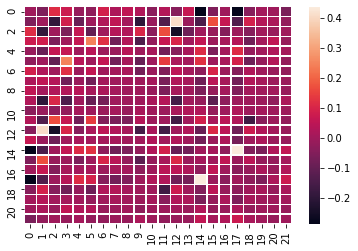

In [110]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

#uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(heatmap, linewidth=0.5)
plt.show()

In [113]:
import pandas as pd
df = pd.DataFrame(heatmap)
df.columns = features
df.to_csv('interaction.csv')

In [86]:
interactions_mat[0]

tensor([ 0.0169,  0.0421, -0.0582, -0.0793,  0.0332,  0.0263, -0.2359, -0.0064,
         0.0419, -0.1801,  0.1765, -0.0812,  0.4820, -0.0174,  0.1234,  0.2688],
       grad_fn=<SelectBackward>)

In [106]:
heatmap = np.zeros((22,22))
heatmap.shape

(22, 22)

In [103]:
n_features

22